# Basic Example: Train a MOFA model

This notebook shows a simple way to train a MOFA [1] model with additional sparsity priors. We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays [2].

[1] Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
[2] Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
from data_loader import load_CLL

from famo.core import CORE
from famo.plotting import (
    plot_factor,
    plot_factor_correlation,
    plot_top_weights,
    plot_training_curve,
    plot_variance_explained,
    plot_weights,
)

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Preprocess Data

In [3]:
# Load CLL data
mdata = load_CLL()

# Normalize and log transform mRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(



## Example 1: Run Factor Analysis

In a first experiment, we will just use all four views and run the factorization. Each experiment consists of two necessary steps:

1) Create a new model instance: `model = CORE()`
3) Train the model: `model.fit(n_factors=15, data=mdata)`

To make your life simple, we only require you to specify the number of factors. In Example 2, we will show you how to deviate from the default parameters and customize your model. For simplicity we will model all data with a Gaussian noise model.
In contrast to the original MOFA definition, we place a Horseshoe sparsity prior [3] on the weights.

[3] Carvalho, Carlos M., Nicholas G. Polson, and James G. Scott. "Handling sparsity via the horseshoe." Artificial intelligence and statistics. PMLR, 2009.

In [4]:
# Run model with MuData object
model = CORE(device="cuda")
model.fit(
    data=mdata,
    n_factors=20,
    likelihoods={
        "mrna": "Normal",
        "drugs": "Normal",
        "mutations": "Bernoulli",
        "methylation": "Normal",
    },
    factor_prior="Normal",
    weight_prior="ARD_Spike_and_Slab",
    n_particles=1,
    lr=0.005,
    init_factors="pca",
    early_stopper_patience=500,
    print_every=500,
)

Setting up device...
- No device id given. Using default device: 0
- Running all computations on `cuda:0`
Fitting model...
- Checking compatibility of provided likelihoods with data.
  - mrna: Normal
  - drugs: Normal
  - mutations: Bernoulli
  - methylation: Normal
- Centering group_1/drugs...
- Centering group_1/methylation...
- Centering group_1/mrna...


alt.Chart(...)

Initializing factors using `pca` method...
{'drugs': 1.2903985319067899, 'methylation': 0.7449880544302483, 'mrna': 0.6408365361310203, 'mutations': 1.3237768775319414}
Decaying learning rate over 10000 iterations.
Setting training seed to `2408121310`.
Cleaning parameter store.
Epoch:       0 | Time:       2.63s | Loss:   10013.40
Epoch:     500 | Time:      46.97s | Loss:    6334.72
Epoch:    1000 | Time:      93.50s | Loss:    5934.72
Epoch:    1500 | Time:     137.79s | Loss:    5818.83
Epoch:    2000 | Time:     181.01s | Loss:    5798.82
Epoch:    2500 | Time:     231.63s | Loss:    5811.91
Epoch:    3000 | Time:     271.96s | Loss:    5747.98
Epoch:    3500 | Time:     310.79s | Loss:    5756.06
Epoch:    4000 | Time:     349.75s | Loss:    5676.80
Epoch:    4500 | Time:     388.70s | Loss:    5682.23
Training finished after 4752 steps.
R2 for view mutations is 0. Increase the number of factors and/or the number of training epochs.
Saving results...
- Model saved to model_202408

## Plot Results

After training, we can inspect all learned parameters, visualize the loss curve, etc.


### ELBO

In [5]:
# Plot training curve
plot_training_curve(model)

alt.Chart(...)

### Plot a heatmap of the weights

To perform downstream analysis, we need to extract the factor loadings and weights from the model. We can do this by calling the `get_factors()` and `get_weights()` method. This returns a dictionary with the weights for each modality and factors (for each group) respectively.


In [6]:
# Get learned model parameters
factors = model.get_factors()
weights = model.get_weights()

However, we also provide functionality to plot the weights directly.

### Factor Correlation Matrix

In [7]:
plot_factor_correlation(model)

alt.HConcatChart(...)

### Variance Explained Plot

In [8]:
model.factor_names

Index(['Factor 15', 'Factor 1', 'Factor 4', 'Factor 12', 'Factor 20',
       'Factor 6', 'Factor 10', 'Factor 13', 'Factor 2', 'Factor 9',
       'Factor 11', 'Factor 7', 'Factor 16', 'Factor 5', 'Factor 3',
       'Factor 17', 'Factor 8', 'Factor 19', 'Factor 18', 'Factor 14'],
      dtype='object')

In [9]:
# group_name = "group_1"
# df_r2 = model._cache["df_r2"]

# # Create an empty list to hold all the charts
# charts = []

# # Get the variance explained DataFrame for the current group
# r2_df = df_r2[group_name].copy()

# # Convert the DataFrame to long format
# r2_df.index = model.factor_names
# r2_df["index"] = model.factor_names
# r2_df = r2_df.melt("index")
# r2_df.columns = ["Factor", "View", "Variance Explained"]
# r2_df

In [10]:
plot_variance_explained(model)

alt.HConcatChart(...)

### Factor Values

In [11]:
plot_factor(model, factor=1)

alt.VConcatChart(...)

### Top weights per factor

In [12]:
plot_weights(model, "mutations", factor=1)

alt.LayerChart(...)

In [13]:
plot_weights(model, "mutations", factor=5)

alt.LayerChart(...)

In [14]:
plot_top_weights(model, view="mutations", factor=[1, 2, 3, 4, 5], orientation="horizontal")

alt.HConcatChart(...)

In [15]:
import famo

In [16]:
from matplotlib import pyplot as plt

In [17]:
model._cache["factors"]["group_1"].obs_names

Index(['H005', 'H006', 'H007', 'H008', 'H010', 'H011', 'H012', 'H013', 'H014',
       'H015',
       ...
       'H258', 'H259', 'H260', 'H264', 'H265', 'H266', 'H268', 'H270', 'H271',
       'H272'],
      dtype='object', length=200)

In [18]:
mdata.obs_names

Index(['H045', 'H109', 'H024', 'H056', 'H079', 'H164', 'H059', 'H167', 'H113',
       'H049',
       ...
       'H178', 'H166', 'H174', 'H177', 'H259', 'H175', 'H179', 'H050', 'H180',
       'H229'],
      dtype='object', length=200)

In [19]:
model._cache["factors"]["group_1"].obs = mdata.obs.loc[model._cache["factors"]["group_1"].obs_names, :].copy()
model._cache["factors"]["group_1"].obs["IGHV"] = model._cache["factors"]["group_1"].obs["IGHV"].astype(str).astype("category")
model._cache["factors"]["group_1"].obs["trisomy12"] = model._cache["factors"]["group_1"].obs["trisomy12"].astype(str).astype("category")
model._cache["factors"]["group_1"].obs.keys()

Index(['Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV',
       'trisomy12'],
      dtype='object')

In [20]:
model.factor_names

Index(['Factor 15', 'Factor 1', 'Factor 4', 'Factor 12', 'Factor 20',
       'Factor 6', 'Factor 10', 'Factor 13', 'Factor 2', 'Factor 9',
       'Factor 11', 'Factor 7', 'Factor 16', 'Factor 5', 'Factor 3',
       'Factor 17', 'Factor 8', 'Factor 19', 'Factor 18', 'Factor 14'],
      dtype='object')

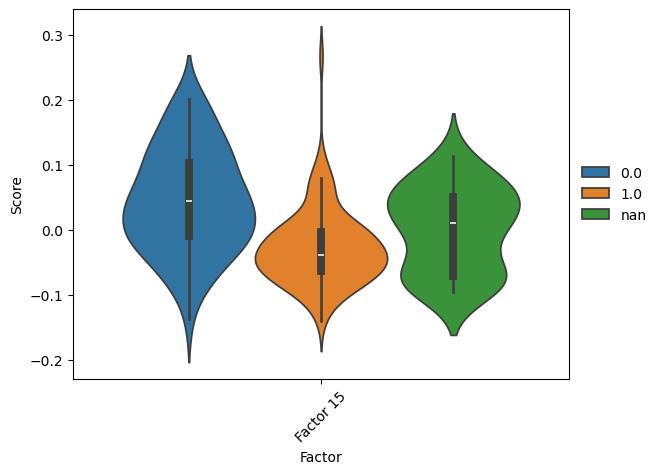

<Axes: xlabel='Factor', ylabel='Score'>

In [21]:
famo.plotting.violinplot(model, factor_idx=1, groupby="IGHV")

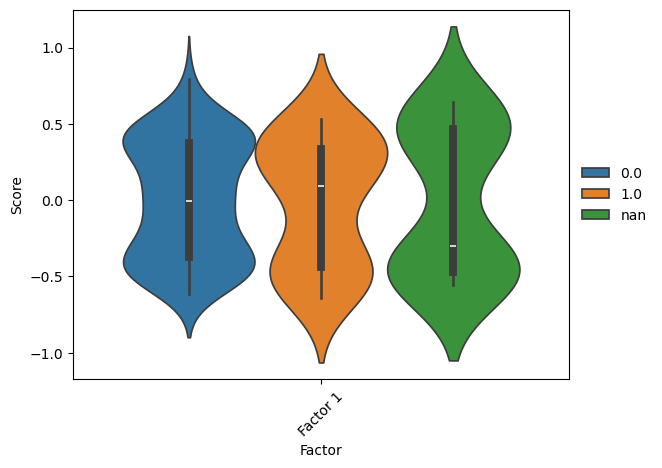

<Axes: xlabel='Factor', ylabel='Score'>

In [22]:
famo.plotting.violinplot(model, factor_idx=2, groupby="trisomy12")

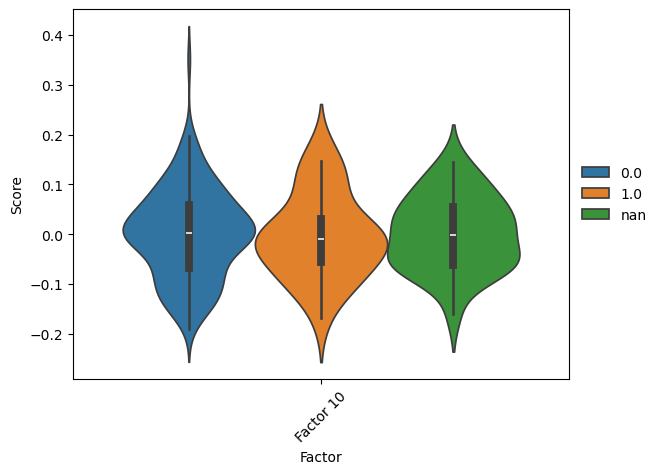

<Axes: xlabel='Factor', ylabel='Score'>

In [23]:
famo.plotting.violinplot(model, factor_idx=7, groupby="trisomy12")

In [24]:
from famo.utils_downstream import test

In [25]:
from famo import feature_sets as fs

In [26]:
gene_sets = fs.from_gmt("c2.cp.reactome.v2023.2.Hs.symbols.gmt")
gene_sets

<FeatureSets 'c2.cp.reactome.v2023.2.Hs.symbols.gmt' with 1692 feature sets>

In [27]:
gene_sets = gene_sets.filter(
    model.feature_names["mrna"], min_fraction=0.1, min_count=15
)
gene_sets

<FeatureSets 'c2.cp.reactome.v2023.2.Hs.symbols.gmt' with 307 feature sets>

In [28]:
gene_set_mask = gene_sets.to_mask(model.feature_names["mrna"])
gene_set_mask

,A1CF,A2M,A2ML1,AAED1,AAK1,AANAT,AASS,AATK,ABCA1,ABCA12,...,ZP3,ZPBP2,ZSCAN1,ZSCAN10,ZSCAN20,ZSCAN23,ZSCAN4,ZSWIM5,ZYG11A,pk
REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_HINDBRAIN_DEVELOPMENT_DURING_EARLY_EMBRYOGENESIS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_ACTIVATION_OF_MATRIX_METALLOPROTEINASES,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POSTSYNAPTIC_EVENTS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_ADAPTIVE_IMMUNE_SYSTEM,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_ADHERENS_JUNCTIONS_INTERACTIONS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACTOME_VESICLE_MEDIATED_TRANSPORT,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_VIRAL_INFECTION_PATHWAYS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_VISUAL_PHOTOTRANSDUCTION,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
REACTOME_VOLTAGE_GATED_POTASSIUM_CHANNELS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
test_results_pos = test(model, "mrna", feature_sets=gene_set_mask, sign="pos")
test_results_neg = test(model, "mrna", feature_sets=gene_set_mask, sign="neg")

100%|████████████████████████████████████████| 307/307 [00:02<00:00, 127.18it/s]


In [30]:
test_df = test_results_pos["p_adj"].copy()

In [31]:
for k in range(model.n_factors):
    print(model.factor_names[k])
    print(test_df.columns[test_df.iloc[k, :] < 0.05])

Factor 15
Index(['REACTOME_SIGNALING_BY_NOTCH3'], dtype='object')
Factor 1
Index([], dtype='object')
Factor 4
Index([], dtype='object')
Factor 12
Index([], dtype='object')
Factor 20
Index([], dtype='object')
Factor 6
Index(['REACTOME_GPER1_SIGNALING', 'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_RUNX2'], dtype='object')
Factor 10
Index(['REACTOME_ATTENUATION_PHASE',
       'REACTOME_CELLULAR_RESPONSE_TO_HEAT_STRESS',
       'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
       'REACTOME_HSF1_DEPENDENT_TRANSACTIVATION',
       'REACTOME_HSP90_CHAPERONE_CYCLE_FOR_STEROID_HORMONE_RECEPTORS_SHR_IN_THE_PRESENCE_OF_LIGAND',
       'REACTOME_INTERFERON_SIGNALING', 'REACTOME_INTERLEUKIN_10_SIGNALING',
       'REACTOME_INTERLEUKIN_4_AND_INTERLEUKIN_13_SIGNALING',
       'REACTOME_NGF_STIMULATED_TRANSCRIPTION',
       'REACTOME_NUCLEAR_EVENTS_KINASE_AND_TRANSCRIPTION_FACTOR_ACTIVATION',
       'REACTOME_PKR_MEDIATED_SIGNALING',
       'REACTOME_REGULATION_OF_HSF1_MEDIATED_HEAT_SHOCK_RESPONSE'],
    

In [32]:
import gseapy as gp
from gseapy import barplot

In [33]:
relevant_factors = model.factor_names.tolist()[:5]

In [34]:
model._cache["weights"]["mrna"].to_df().head()

,A1CF,A2M,A2ML1,AAED1,AAK1,AANAT,AASS,AATK,ABCA1,ABCA12,...,ZP3,ZPBP2,ZSCAN1,ZSCAN10,ZSCAN20,ZSCAN23,ZSCAN4,ZSWIM5,ZYG11A,pk
Factor 15,0.007248,-0.010910,-0.044862,-0.061463,-0.110758,0.064722,-0.014396,0.049991,-0.009947,0.017252,...,-0.032335,-0.011046,0.016094,0.030351,-0.063047,-0.017830,-0.010622,-0.043746,-0.009395,0.021938
Factor 1,-0.166680,-0.021736,-0.181452,0.036463,0.036314,0.015749,0.003040,-0.099316,-0.011992,0.019712,...,0.021697,0.018978,-0.387077,-0.048880,0.034898,-0.008406,-0.019915,0.024333,-0.008597,0.032889
Factor 4,-0.173725,0.453804,0.258237,-0.487114,0.364252,0.006131,0.068568,0.463955,-0.569524,-0.077908,...,0.011435,-0.459904,-0.151591,-0.034002,-0.046339,0.116831,-0.253440,-0.468364,-0.140707,0.909327
Factor 12,-0.382350,-0.105023,-0.054539,0.038589,0.043344,-0.815859,0.151095,0.174473,0.051577,-0.438335,...,-0.083718,-0.357874,0.074898,-0.058821,-0.122088,-0.074406,-0.116815,0.228884,-0.086696,0.087462
Factor 20,-0.005011,0.005463,-0.074940,-0.121621,-0.027840,0.042170,0.000128,-0.012795,-0.008052,0.003407,...,-0.002345,-0.096302,-0.121853,0.028549,0.022227,-0.002885,-0.019059,0.096075,-0.015710,0.025613


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


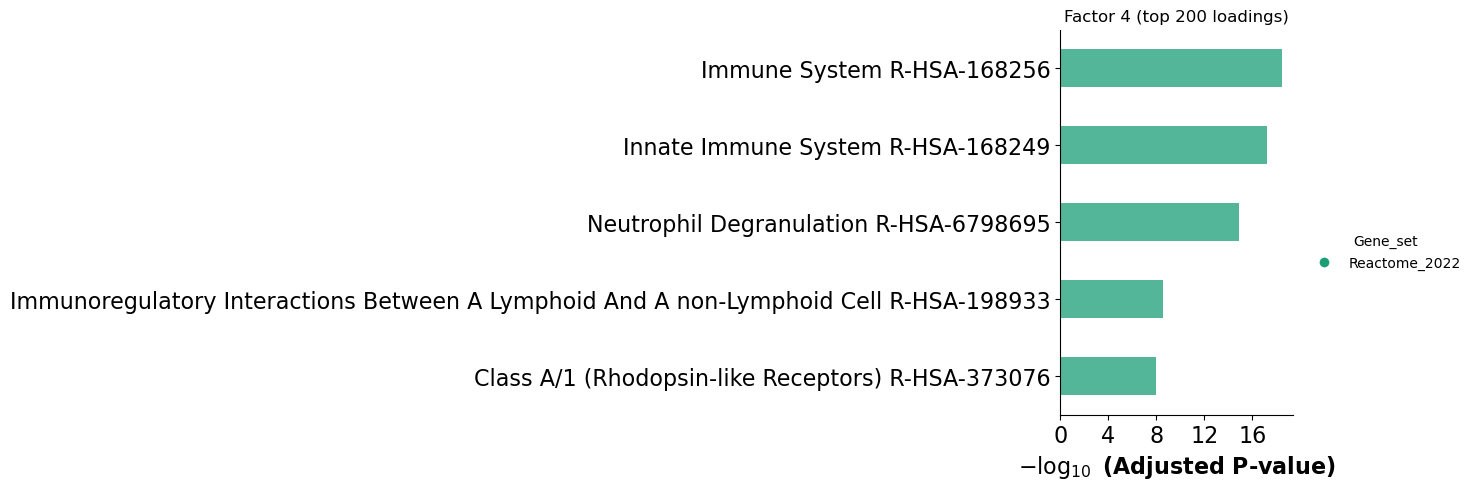

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


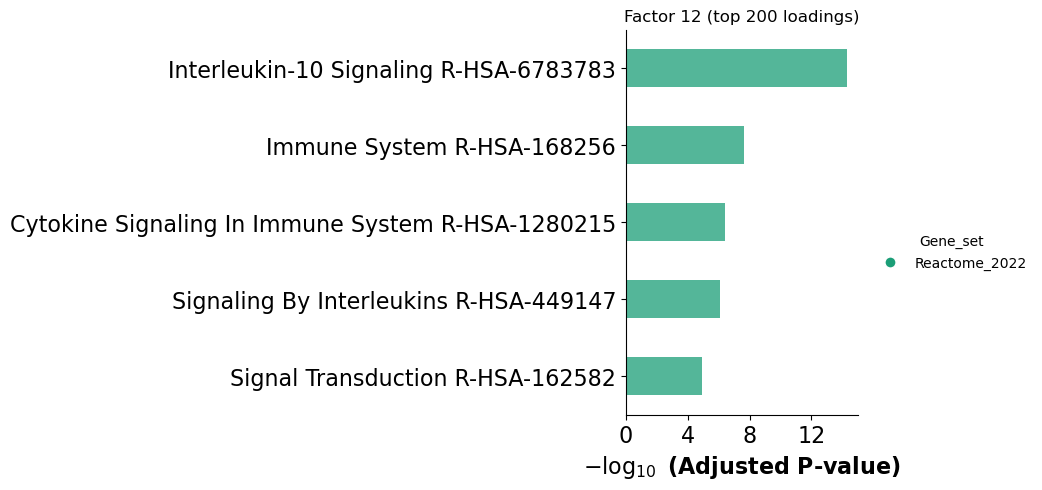

In [35]:
top = 200
# TODO: direction important if vanilla muvi
direction = "pos"
for factor_idx in relevant_factors:
    if factor_idx not in model.factor_names:
        continue
    gl = model._cache["weights"]["mrna"].to_df().loc[factor_idx, :].sort_values(ascending=False).index.tolist()
    if top is not None:
        gl = gl[:top]
    enr = gp.enrichr(
        gene_list=gl,
        gene_sets=[
            # "MSigDB_Hallmark_2020",
            # "KEGG_2021_Human",
            "Reactome_2022",
            # "GO_Biological_Process_2023",
        ],
        organism="human",
        outdir=None,
    )

    try:
        # categorical scatterplot
        ax = barplot(
            enr.results,
            column="Adjusted P-value",
            group="Gene_set",  # set group, so you could do a multi-sample/library comparsion
            size=10,
            top_term=5,
            figsize=(3, 5),
            color=["#1b9e77", "#d95f02", "#7570b3", "#e7298a"],  # set colors for group
            # color = {'MSigDB_Hallmark_2020':'blue', 'KEGG_2021_Human': 'salmon', 'Reactome_2022':'red'}
        )
        plt.title(f"{factor_idx} (top {top} loadings)")
        plt.show()
    except ValueError as e:
        print(e)